# Model intepretation

In [ ]:
#uncomment this below code to install imblearn package
# !pip install imbalanced-learn

In [ ]:
# !pip install scikit-optimize

In [1]:
import pandas as pd
import numpy as np
import sklearn

#statistics
from scipy.stats import chi2_contingency, ttest_ind

# import cudf #gpu-powered DataFrame (Pandas alternative)

#imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, RepeatedEditedNearestNeighbours
from imblearn.pipeline import Pipeline

#preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

#hyperparameter search
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

#internal validation
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, PredefinedSplit, RandomizedSearchCV


#performance metrices
from sklearn.metrics import make_scorer, confusion_matrix, classification_report, f1_score, balanced_accuracy_score, r2_score, auc, average_precision_score, roc_auc_score, recall_score, roc_curve, accuracy_score

#Models selection
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
# from cuml.svm import SVC #gpu-powered SVM


#save and load trained model
import pickle

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import os

random_state = 42

In [2]:
gridSearchData, crossValData, internalEvaluationData, externalEvaluationData = pickle.load(open('../../Clean_data/dataset_scaled_2vs1_25102024.sav', 'rb'))
features = pd.read_csv('../../Clean_data/data_features_2vs1_2016-2018_21102024.csv', low_memory=False)

In [3]:
#Define feature candidates

features_columns = gridSearchData.columns.to_list()
exclude_columns = ['patid', 'practice_id', 'set', #identifier
                   'BMI', #use the categorical instead
                   'ethnicity', #use ethnic_group instead
                   'Spacer',  #all zero
                   
                   'outcome_3months', 'outcome_6months', 'outcome_9months', 'outcome_12months', 'outcome_15months', 'outcome_18months', 
                   'outcome_21months', 'outcome_24months', 'outcome_combined_6months', 'outcome_combined_9months', 'outcome_combined_12months', 
                   'outcome_combined_15months', 'outcome_combined_18months', 'outcome_combined_24months', '3months', '6months', '12months', '24months', #outcomes variable
                   
                   'postcode_district', 'County', 'LocalAuthority', 'OutputAreaClassification', #location related variables, use IMD decile only
                   
                   'age_cat', 'ICS_medication_possesion_ratio_cat', 'numOCS_cat', 'numOCSEvents_cat', 'numOCSwithLRTI_cat', 'numAcuteRespEvents_cat', 
                   'numAntibioticsEvents_cat', 'numAntibioticswithLRTI_cat', 'numAsthmaAttacks_cat', 'numHospEvents_cat', 'numPCS_cat', 'numPCSAsthma_cat', 
                   'numAsthmaManagement_cat', 'numAsthmaReview_cat', 'numAsthmaMedReview_cat', 'numAsthmaReviewRCP_cat', 'average_daily_dose_ICS_cat', 
                   'prescribed_daily_dose_ICS_cat', #use continous vars instead
                   
                   'count_rhinitis', 'count_cardiovascular', 'count_heartfailure',
                   'count_psoriasis', 'count_anaphylaxis', 'count_diabetes', 'count_ihd',
                   'count_anxiety', 'count_eczema', 'count_nasalpolyps',
                   'count_paracetamol', 'count_nsaids', 'count_betablocker', #use binary ones
                   
                   'paracetamol', 'nsaids', 'betablocker', #no data in evaluation
                                      
                  ]
# exclude_columns = exclude_columns + [x for x in features_columns if '_count' in x] #filter out commorbid count variables
features_columns = [x for x in features_columns if x not in exclude_columns]
print('Features size: ', len(features_columns))
print(features_columns)

Features size:  87
['sex', 'rhinitis', 'cardiovascular', 'heartfailure', 'psoriasis', 'anaphylaxis', 'diabetes', 'ihd', 'anxiety', 'eczema', 'nasalpolyps', 'asthmaPlan', 'BMI_cat_normal', 'BMI_cat_not recorded', 'BMI_cat_obese', 'BMI_cat_overweight', 'BMI_cat_underweight', 'ethnic_group_Asian', 'ethnic_group_Black', 'ethnic_group_Mixed', 'ethnic_group_Other', 'ethnic_group_White', 'ethnic_group_not recorded', 'smokingStatus_current', 'smokingStatus_former', 'smokingStatus_never', 'imd_decile_0', 'imd_decile_1', 'imd_decile_2', 'imd_decile_3', 'imd_decile_4', 'imd_decile_5', 'imd_decile_6', 'imd_decile_7', 'imd_decile_8', 'imd_decile_9', 'imd_decile_10', 'CharlsonScore_0.0', 'CharlsonScore_1.0', 'CharlsonScore_2.0', 'CharlsonScore_3.0', 'CharlsonScore_4.0', 'CharlsonScore_5.0', 'CharlsonScore_6.0', 'CharlsonScore_7.0', 'CharlsonScore_8.0', 'CharlsonScore_9.0', 'CharlsonScore_10.0', 'CharlsonScore_11.0', 'CharlsonScore_12.0', 'PEFStatus_60-80', 'PEFStatus_less than 60', 'PEFStatus_more t

In [4]:
X = crossValData[features_columns]
X_internalVal = internalEvaluationData[features_columns]
X_externalVal = externalEvaluationData[features_columns]


print(X.shape)
print(X_internalVal.shape)
print(X_externalVal.shape)


target_outcomes = [
    'outcome_3months', 'outcome_6months', 'outcome_9months', 
    'outcome_12months',
] 
# target_outcomes = ['12months'] 
model_names = [
    'LR', 'Lasso', 'ElasticNet', 
    'DT', 'RF', 
    'XGB'
              ]

(444393, 87)
(121714, 87)
(19860, 87)


In [5]:
data = pd.read_csv('../../MODELS/externalValResult.csv')

In [6]:
data

,model_name,fold,outcome,class_ratio,auc,auprc,model_num
0,LR,NaN,outcome_12months,0.130031,0.7675,0.4287,0
1,ElasticNet,NaN,outcome_12months,0.130031,0.7676,0.4287,1
2,DT,NaN,outcome_12months,0.130031,0.7696,0.4181,2
3,RF,NaN,outcome_12months,0.130031,0.7831,0.4484,3
4,XGB,NaN,outcome_12months,0.130031,0.7846,0.4502,4
5,LR,NaN,outcome_3months,0.048745,0.7455,0.1937,5
6,ElasticNet,NaN,outcome_3months,0.048745,0.7455,0.1936,6
7,DT,NaN,outcome_3months,0.048745,0.7297,0.1684,7
8,RF,NaN,outcome_3months,0.048745,0.7593,0.1946,8
9,XGB,NaN,outcome_3months,0.048745,0.7644,0.1980,9


Text(0.5, 21.70624999999974, 'Method')

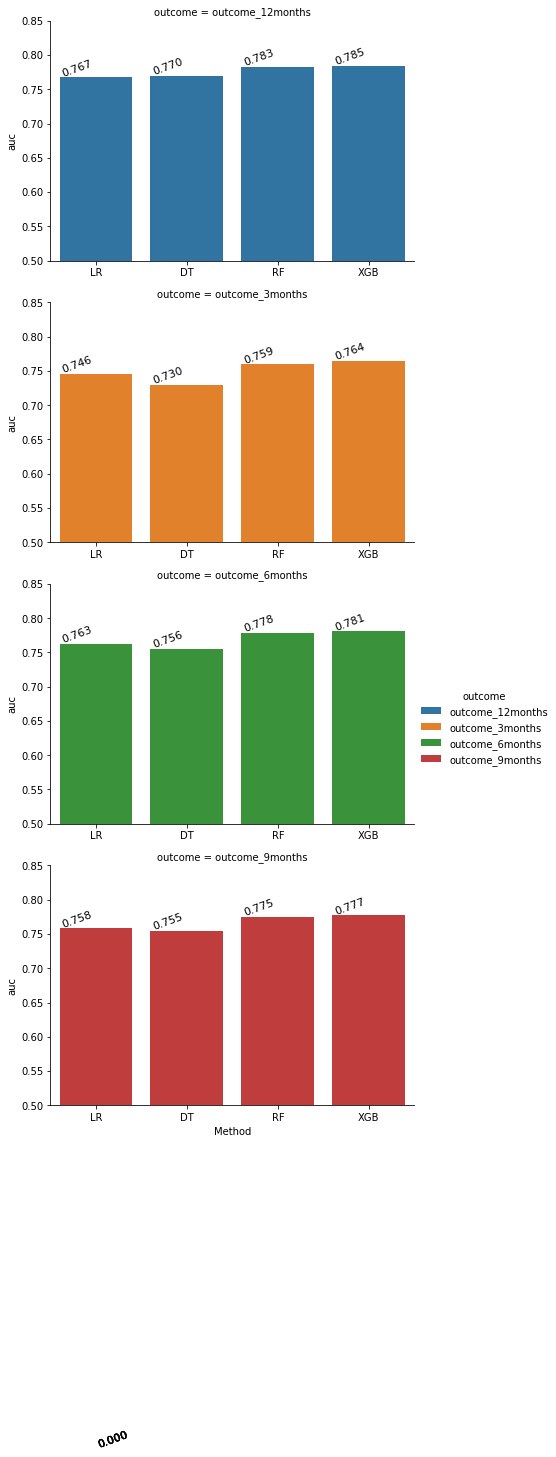

In [7]:
#PLOT
# data = combine
# data = combine[(combine.outcome=='outcome_12months')]
data = data[data.model_name!='ElasticNet']
bar = sns.catplot(x = 'model_name',       # x variable name
            y = 'auc',       # y variable name            
            data=data,
            kind = "bar",
            hue = 'outcome',
            # hue_order=['10-fold CV', 'Evaluation Set', 'Wales', 'Scotland'],
            height=4,
            row='outcome',
            aspect=1.5,
            errorbar = None, sharex=False)

for items in bar.axes:
    for ax in items:
        for p in ax.patches:
            ax.text(p.get_x() + 0.01, 
                p.get_height() * 1.002, 
                '{0:.3f}'.format(p.get_height()), 
                color='black', rotation=20, fontsize=11)

ax.set_ylim(0.5, .85)
# ax.set_ylabel('AUC Score', fontsize=13)
ax.set_xlabel('Method', fontsize=10)
# ax.set_xticklabels(fontsize=20)

# Feature importance

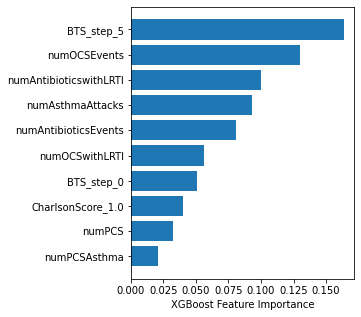

In [12]:
best_model_dt = pickle.load(open('../../MODELS/TestResult/outcome_12months_XGB.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_dt.feature_importances_.argsort()
plt.figure(figsize=(4,5))
plt.barh(X.columns[sorted_idx][-10:], best_model_dt.feature_importances_[sorted_idx][-10:])
plt.xlabel("XGBoost Feature Importance")
plt.show()
dttop10 = X.columns[sorted_idx][-10:]

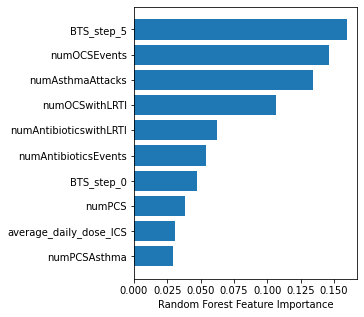

In [13]:
best_model_dt = pickle.load(open('../../MODELS/TestResult/outcome_12months_RF.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_dt.feature_importances_.argsort()
plt.figure(figsize=(4,5))
plt.barh(X.columns[sorted_idx][-10:], best_model_dt.feature_importances_[sorted_idx][-10:])
plt.xlabel("Random Forest Feature Importance")
plt.show()
dttop10 = X.columns[sorted_idx][-10:]

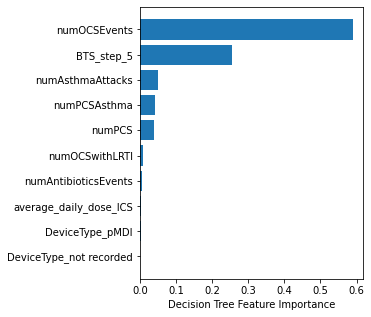

In [14]:
best_model_dt = pickle.load(open('../../MODELS/TestResult/outcome_12months_DT.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_dt.feature_importances_.argsort()
plt.figure(figsize=(4,5))
plt.barh(X.columns[sorted_idx][-10:], best_model_dt.feature_importances_[sorted_idx][-10:])
plt.xlabel("Decision Tree Feature Importance")
plt.show()
dttop10 = X.columns[sorted_idx][-10:]

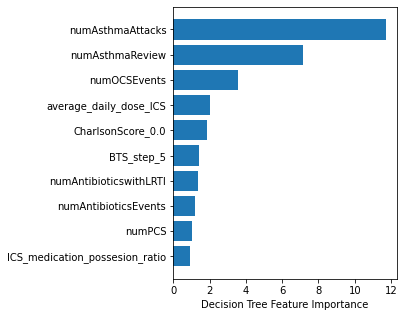

In [15]:
best_model_dt = pickle.load(open('../../MODELS/TestResult/outcome_12months_LR.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_dt.coef_[0].argsort()
plt.figure(figsize=(4,5))
plt.barh(X.columns[sorted_idx][-10:], best_model_dt.coef_[0][sorted_idx][-10:])
plt.xlabel("Decision Tree Feature Importance")
plt.show()
dttop10 = X.columns[sorted_idx][-10:]

# Clinical utility

In [8]:
features_columns = gridSearchData.columns.to_list()
exclude_columns = ['patid', 'practice_id', 'set', #identifier
                   'BMI', #use the categorical instead
                   'ethnicity', #use ethnic_group instead
                   'Spacer',  #all zero
                   
                   'outcome_3months', 'outcome_6months', 'outcome_9months', 'outcome_12months', 'outcome_15months', 'outcome_18months', 
                   'outcome_21months', 'outcome_24months', 'outcome_combined_6months', 'outcome_combined_9months', 'outcome_combined_12months', 
                   'outcome_combined_15months', 'outcome_combined_18months', 'outcome_combined_24months', '3months', '6months', '12months', '24months', #outcomes variable
                   
                   'postcode_district', 'County', 'LocalAuthority', 'OutputAreaClassification', #location related variables, use IMD decile only
                   
                   'age_cat', 'ICS_medication_possesion_ratio_cat', 'numOCS_cat', 'numOCSEvents_cat', 'numOCSwithLRTI_cat', 'numAcuteRespEvents_cat', 
                   'numAntibioticsEvents_cat', 'numAntibioticswithLRTI_cat', 'numAsthmaAttacks_cat', 'numHospEvents_cat', 'numPCS_cat', 'numPCSAsthma_cat', 
                   'numAsthmaManagement_cat', 'numAsthmaReview_cat', 'numAsthmaMedReview_cat', 'numAsthmaReviewRCP_cat', 'average_daily_dose_ICS_cat', 
                   'prescribed_daily_dose_ICS_cat', #use continous vars instead
                   
                   'count_rhinitis', 'count_cardiovascular', 'count_heartfailure',
                   'count_psoriasis', 'count_anaphylaxis', 'count_diabetes', 'count_ihd',
                   'count_anxiety', 'count_eczema', 'count_nasalpolyps',
                   'count_paracetamol', 'count_nsaids', 'count_betablocker', #use binary ones
                   
                   'paracetamol', 'nsaids', 'betablocker', #no data in evaluation
                                      
                  ]
# exclude_columns = exclude_columns + [x for x in features_columns if '_count' in x] #filter out commorbid count variables
features_columns = [x for x in features_columns if x not in exclude_columns]
print('Features size: ', len(features_columns))
print(features_columns)

Features size:  87
['sex', 'rhinitis', 'cardiovascular', 'heartfailure', 'psoriasis', 'anaphylaxis', 'diabetes', 'ihd', 'anxiety', 'eczema', 'nasalpolyps', 'asthmaPlan', 'BMI_cat_normal', 'BMI_cat_not recorded', 'BMI_cat_obese', 'BMI_cat_overweight', 'BMI_cat_underweight', 'ethnic_group_Asian', 'ethnic_group_Black', 'ethnic_group_Mixed', 'ethnic_group_Other', 'ethnic_group_White', 'ethnic_group_not recorded', 'smokingStatus_current', 'smokingStatus_former', 'smokingStatus_never', 'imd_decile_0', 'imd_decile_1', 'imd_decile_2', 'imd_decile_3', 'imd_decile_4', 'imd_decile_5', 'imd_decile_6', 'imd_decile_7', 'imd_decile_8', 'imd_decile_9', 'imd_decile_10', 'CharlsonScore_0.0', 'CharlsonScore_1.0', 'CharlsonScore_2.0', 'CharlsonScore_3.0', 'CharlsonScore_4.0', 'CharlsonScore_5.0', 'CharlsonScore_6.0', 'CharlsonScore_7.0', 'CharlsonScore_8.0', 'CharlsonScore_9.0', 'CharlsonScore_10.0', 'CharlsonScore_11.0', 'CharlsonScore_12.0', 'PEFStatus_60-80', 'PEFStatus_less than 60', 'PEFStatus_more t

# Start HERE

In [9]:
# allData = pd.concat([gridSearchData, crossValData, internalEvaluationData, externalEvaluationData])
# allData.reset_index(drop=True, inplace=True)
externalEvaluationData = externalEvaluationData.merge(features[['patid', 'practice_id.x']], on = 'patid', how='inner')
externalEvaluationData.reset_index(drop=True, inplace=True)

In [10]:
def extract_event_rate(x):
    event_rate = externalEvaluationData[externalEvaluationData['practice_id.x']==x]['outcome_12months'].value_counts(normalize=True).tolist()
    if len(event_rate) > 1:
        return event_rate[1]
    else:
        return 0
practices = externalEvaluationData.groupby('practice_id.x').count()[['patid']]
practices['practice_id'] = practices.index
practices['practice_id'] = practices['practice_id'].apply(lambda x: int(x))
practices['event_rate'] = practices['practice_id'].apply(lambda x: extract_event_rate(x))
practices.reset_index(drop=True, inplace=True)
practices.rename(columns={'patid': 'n_patients'}, inplace=True)

<Axes: xlabel='n_patients', ylabel='event_rate'>

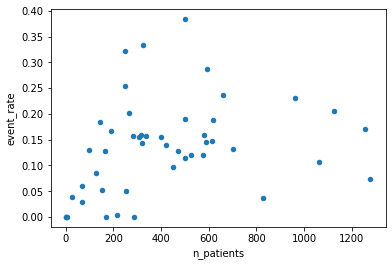

In [11]:
practices.plot.scatter(x='n_patients', y='event_rate')

<Axes: >

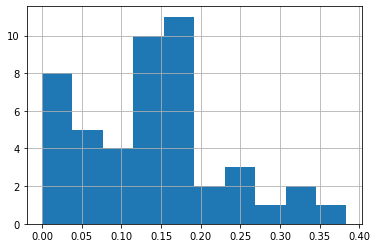

In [12]:
practices.event_rate.hist()

In [13]:
practices[(practices['n_patients']>100) & ((practices['event_rate']>=.1) & (practices['event_rate']<.2))]

,n_patients,practice_id,event_rate
0,617,6,0.188006
3,703,107,0.132290
7,499,188,0.190381
8,1065,208,0.107042
9,191,238,0.167539
12,308,411,0.155844
14,337,460,0.157270
18,146,506,0.184932
21,319,579,0.144201
22,165,751,0.127273


In [14]:
#practice selection
practice_ids = [913, 208, 1105] #with event rate <.1, 0.1-0.2, >0.2, respectively
capacity_percent = .5
output = []
lrmodel = pickle.load(open('../../MODELS/TestResult/outcome_12months_LR.sav', 'rb'))
xgbmodel = model = pickle.load(open('../../MODELS/TestResult/outcome_12months_XGB.sav', 'rb'))
lrmodel_calibrated = pickle.load(open('../../MODELS/Calibrated/outcome_12months_LR.sav', 'rb'))
xgbmodel_calibrated = pickle.load(open('../../MODELS/Calibrated/outcome_12months_XGB.sav', 'rb'))
modelnames = ['LR', 'XGB']
models = [lrmodel, xgbmodel]
calib_models = [lrmodel_calibrated, xgbmodel_calibrated]

for practice_id in practice_ids:
    print(f'practice id: {practice_id}')
    
    #PRIOR
    n = practices[practices.practice_id == practice_id]['n_patients'].tolist()[0]
    event_rate = practices[practices.practice_id == practice_id]['event_rate'].tolist()[0]
    high_risk_patients = int(np.round(n*event_rate))
    low_risk_patients = int(n - high_risk_patients)
    capacity = int(np.round(capacity_percent*n))
    print(f'Total people living with asthma: {n}')
    print(f'Event rate: {event_rate}')
    print(f'Number of patients with high risk of asthma attack: {high_risk_patients}')
    print(f'Number of patients with low risk of asthma attack: {low_risk_patients}')
    print(f'Total capacity of in-person asthma annual review: {capacity}')

    #Model prediction
    for modelname, model, calibrated_model in zip(modelnames, models, calib_models):
        X_test = externalEvaluationData[externalEvaluationData['practice_id.x']==practice_id][features_columns]
        y_test = externalEvaluationData[externalEvaluationData['practice_id.x']==practice_id]['outcome_12months']
        
        step = .005 #how granular we want to have the plot
        thresholds = [round(i * step, 4) for i in range(int(1/step) + 1)]
        for threshold in thresholds:
            # print(threshold)
            preds = model.predict_proba(X_test)[:,1] #uncalibrated
            preds = calibrated_model.predict_proba(preds)  #calibrated
            preds = [1 if x >= threshold else 0 for x in preds]
            tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
            spec = tn /(tn+fp)
            sens = tp /(tp+fn)
            capacity_diff = (tp+fp)/capacity * 100
            output.append([practice_id, n, event_rate, modelname, threshold, tp, fp, tn, fn, spec, sens, capacity, capacity_diff])
        print("==================================================================================================")
print('done')

practice id: 913
Total people living with asthma: 828
Event rate: 0.036231884057971016
Number of patients with high risk of asthma attack: 30
Number of patients with low risk of asthma attack: 798
Total capacity of in-person asthma annual review: 414
[10:06:59] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[10:06:59] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure


/home/abudiarto/miniconda3/envs/tf2.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:06:59] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


practice id: 208
Total people living with asthma: 1065
Event rate: 0.10704225352112676
Number of patients with high risk of asthma attack: 114
Number of patients with low risk of asthma attack: 951
Total capacity of in-person asthma annual review: 532
practice id: 1105
Total people living with asthma: 503
Event rate: 0.3836978131212724
Number of patients with high risk of asthma attack: 193
Number of patients with low risk of asthma attack: 310
Total capacity of in-person asthma annual review: 252
done


In [15]:
output = pd.DataFrame(output, columns=['practice', 'n', 'event_rate', 'model', 'threshold', 'TP', 'FP', 'TN', 'FN', 'SPEC', 'SENS', 'Capacity', 'CAP_DIFF'])
output.dropna(inplace=True)
output.drop_duplicates('CAP_DIFF', inplace=True)

In [31]:
output.to_csv('../../Clean_data/clinical_utility_output.csv', index_label=False, index=False)

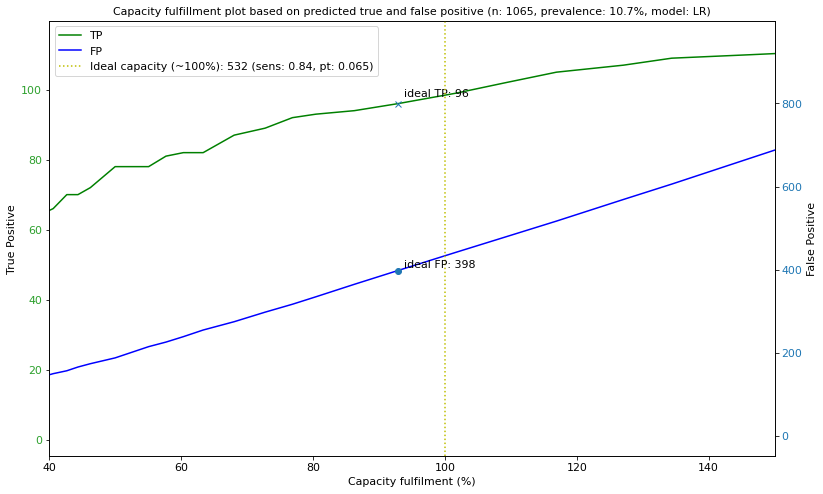

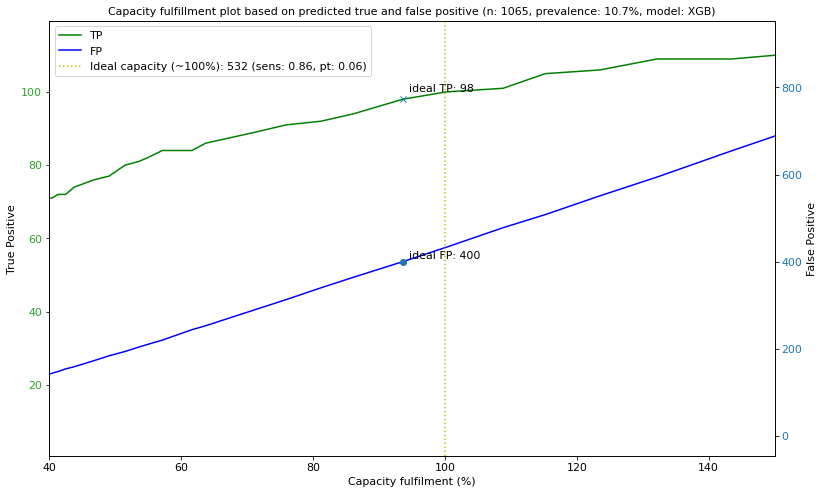

In [32]:
x = 'CAP_DIFF'
y_1 = 'TP'
y_2 = 'FP'
max_xlim = 150 #max % pf capacity to be plotted


for modelname in modelnames:
    data_output = output[(output.model==modelname) & (output.practice == practice_ids[1])]
    fig, ax = plt.subplots(figsize=(13,8))
    data_output.plot(ax = ax, x=x, y=y_1, color='g', label=y_1)
    # ax.title.set_text('PM2.5 Design Values')
    ax.set_xlim(40,max_xlim)
    # ax.set_ylim(0,data_output[data_output.CAP_DIFF < max_xlim][y_2].values[0]) #set ylim based on the y2 value at CAP_DIFF ~ max_xlim
    # ax.set_ylim(0,data_output[y_1].max()) #set ylim based on the max value of y1
    ax.tick_params(axis='y', labelcolor='tab:green')
    ax.set_ylabel('True Positive')
    ax.set_xlabel('Capacity fulfilment (%)')
    
    # ax.set_xticks(IVdv.index)
    
    ax2=ax.twinx()
    ax2.plot(data_output[x], data_output[y_2], color='b', 
            label=y_2)
    
    # ax2.set_ylim(0,data_output[data_output.CAP_DIFF < max_xlim][y_2].values[0]) #set ylim based on the y2 value at CAP_DIFF ~ max_xlim
    # ax2.set_ylim(0,data_output[y_2].max()) #set ylim based on the max value of y2
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylabel('False Positive')

    #plot ideal capacity at 100%
    capacity = data_output.Capacity.values[0]
    x_mark = data_output[(data_output.CAP_DIFF <= 100)].CAP_DIFF.values[0]
    tp_mark = data_output[(data_output.CAP_DIFF == x_mark)].TP.values[0]
    fp_mark = data_output[(data_output.CAP_DIFF == x_mark)].FP.values[0]
    pt_mark = data_output[(data_output.CAP_DIFF == x_mark)].threshold.values[0]
    sens = np.round(data_output[(data_output.CAP_DIFF == x_mark)].SENS.values[0],2)

    ax2.axvline(x=100, color='y', label=f'Ideal capacity (~100%): {capacity} (sens: {sens}, pt: {pt_mark})', ls=':')
    ax.plot(x_mark, tp_mark, ls="", marker="x")
    ax.annotate("ideal TP: "+str(tp_mark), (x_mark+1, tp_mark+2))
    ax2.plot(x_mark, fp_mark, ls="", marker="o")
    ax2.annotate("ideal FP: "+str(fp_mark), (x_mark+1, fp_mark+7))
    # ax2.annotate(f"Ideal probability threshold: {pt_mark}")

    #plot capacity at 130%
    x_mark = data_output[(data_output.CAP_DIFF <= 130)].CAP_DIFF.values[0]
    tp_mark = data_output[(data_output.CAP_DIFF == x_mark)].TP.values[0]
    fp_mark = data_output[(data_output.CAP_DIFF == x_mark)].FP.values[0]
    pt_mark = data_output[(data_output.CAP_DIFF == x_mark)].threshold.values[0]
    sens = np.round(data_output[(data_output.CAP_DIFF == x_mark)].SENS.values[0],2)
    

    # ax2.axvline(x=130, color='r', label=f'130% of capacity: {int(np.round(130/100*capacity))} (sens: {sens}, pt: {pt_mark})', ls='--')
    # ax.plot(x_mark, tp_mark, ls="", marker="x")
    # ax.annotate("TP for 130% capacity: "+str(tp_mark), (x_mark+1, tp_mark+2))
    # ax2.plot(x_mark, fp_mark, ls="", marker="o")
    # ax2.annotate("FP for 130% capacity: "+str(fp_mark), (x_mark+1, fp_mark+7))
    # ax2.annotate(f"Probability threshold fpr 130% capacity: {pt_mark}")
    
    
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    
    ax.legend(lines, labels, loc='upper left')
    n = data_output.n.values[0]
    event_rate = np.round(data_output.event_rate.values[0]*100, 2)
    plt.title(f'Capacity fulfillment plot based on predicted true and false positive (n: {n}, prevalence: {event_rate}%, model: {modelname})')
    # plt.legend()

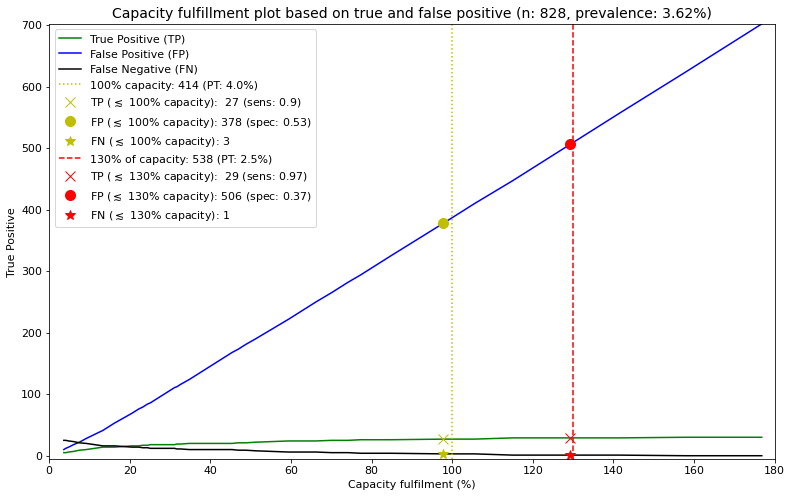

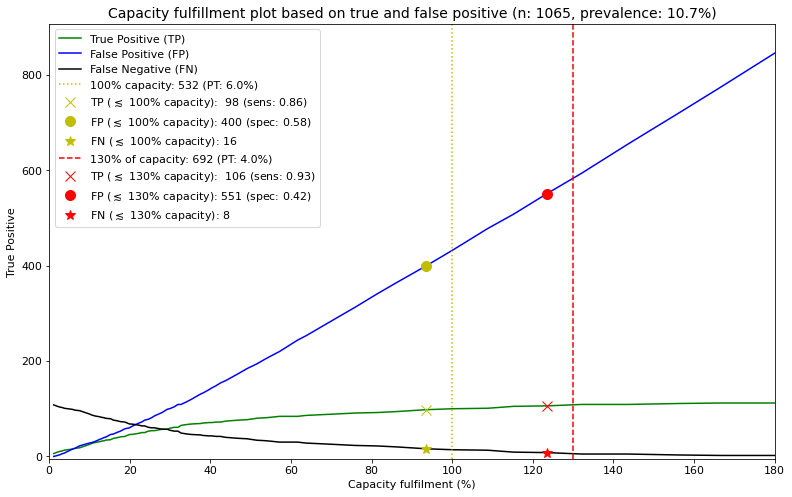

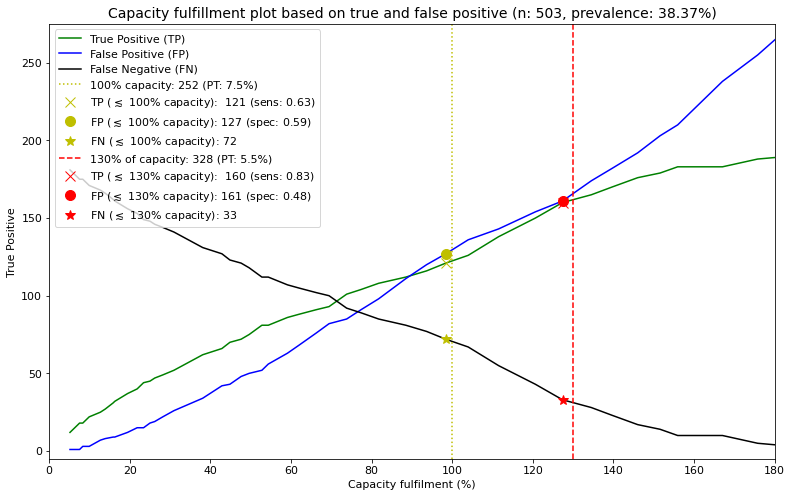

In [46]:
import matplotlib
# 
SMALL_SIZE = 11
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

x = 'CAP_DIFF'
y_1 = 'TP'
y_2 = 'FP'
y_3 = 'FN'
max_xlim = 180 #max % pf capacity to be plotted


for practice_id in practice_ids:
    data_output = output[(output.practice == practice_id)&(output.model=='XGB')]
    fig, ax = plt.subplots(figsize=(13,8))
    data_output.plot(ax = ax, x=x, y=y_1, color='green', label='True Positive (TP)')
    # ax.title.set_text('PM2.5 Design Values')
    ax.set_xlim(0,max_xlim)
    # ax.set_ylim(0,data_output[data_output.CAP_DIFF < max_xlim][y_2].values[0]) #set ylim based on the y2 value at CAP_DIFF ~ max_xlim
    ax.set_ylim(-5,data_output[y_2].max()) #set ylim based on the max value of y1
    # ax.tick_params(axis='y', labelcolor='tab:green')
    ax.set_ylabel('True Positive')
    ax.set_xlabel('Capacity fulfilment (%)')
    
    # ax.set_xticks(IVdv.index)
    
    # ax2=ax.twinx()
    ax.plot(data_output[x], data_output[y_2], color='blue', 
            label='False Positive (FP)')
    
    ax.plot(data_output[x], data_output[y_3], color='black', 
            label='False Negative (FN)')
    
    
    
    # ax2.set_ylim(0,data_output[data_output.CAP_DIFF < max_xlim][y_2].values[0]) #set ylim based on the y2 value at CAP_DIFF ~ max_xlim
    # ax2.set_ylim(0,data_output[y_2].max()) #set ylim based on the max value of y2
    # ax2.tick_params(axis='y', labelcolor='tab:blue')
    # ax2.set_ylabel('False Positive')

    #plot ideal capacity at 100%
    capacity = data_output.Capacity.values[0]
    x_mark = data_output[(data_output.CAP_DIFF <= 100)].CAP_DIFF.values[0]
    tp_mark = data_output[(data_output.CAP_DIFF == x_mark)].TP.values[0]
    fp_mark = data_output[(data_output.CAP_DIFF == x_mark)].FP.values[0]
    fn_mark = data_output[(data_output.CAP_DIFF == x_mark)].FN.values[0]
    pt_mark = data_output[(data_output.CAP_DIFF == x_mark)].threshold.values[0]
    sens = np.round(data_output[(data_output.CAP_DIFF == x_mark)].SENS.values[0],2)
    spec = np.round(data_output[(data_output.CAP_DIFF == x_mark)].SPEC.values[0],2)

    ax.axvline(x=100, color='y', label=f'100% capacity: {capacity} (PT: {pt_mark*100}%)', ls=':')
    ax.plot(x_mark, tp_mark, ls="", color='y', marker="x", markersize=10, label=r"TP ($ \lesssim $ 100% capacity): " + f" {tp_mark} (sens: {sens})")
    # ax.annotate(, (x_mark-50, tp_mark-30))
    ax.plot(x_mark, fp_mark, ls="", color='y', marker="o", markersize=10, label=r"FP ($ \lesssim $ 100% capacity): " + f"{fp_mark} (spec: {spec})")
    ax.plot(x_mark, fn_mark, ls="", color='y', marker="*", markersize=10, label=r"FN ($ \lesssim $ 100% capacity): " + f"{fn_mark}")
    
    
    # ax.annotate(, (x_mark-50, fp_mark+7))
    # ax.annotate(f"Ideal probability threshold: {pt_mark}")

    #plot capacity at 130%
    x_mark = data_output[(data_output.CAP_DIFF <= 130)].CAP_DIFF.values[0]
    tp_mark = data_output[(data_output.CAP_DIFF == x_mark)].TP.values[0]
    fp_mark = data_output[(data_output.CAP_DIFF == x_mark)].FP.values[0]
    fn_mark = data_output[(data_output.CAP_DIFF == x_mark)].FN.values[0]
    pt_mark = data_output[(data_output.CAP_DIFF == x_mark)].threshold.values[0]
    sens = np.round(data_output[(data_output.CAP_DIFF == x_mark)].SENS.values[0],2)
    spec = np.round(data_output[(data_output.CAP_DIFF == x_mark)].SPEC.values[0],2)
    

    ax.axvline(x=130, color='r', label=f'130% of capacity: {int(np.round(130/100*capacity))} (PT: {pt_mark*100}%)', ls='--')
    ax.plot(x_mark, tp_mark, ls="", marker="x", markersize=10, color='r', label=r"TP ($ \lesssim $ 130% capacity): " + f" {tp_mark} (sens: {sens})")
    # ax.annotate(, (x_mark+1, tp_mark-20))
    ax.plot(x_mark, fp_mark, ls="", marker="o", markersize=10, color='r', label=r"FP ($ \lesssim $ 130% capacity): " + f"{fp_mark} (spec: {spec})")
    ax.plot(x_mark, fn_mark, ls="", color='r', marker="*", markersize=10, label=r"FN ($ \lesssim $ 130% capacity): " + f"{fn_mark}")
    
    
    # ax.annotate(, (x_mark+1, fp_mark+7))
    # ax.annotate(f"Probability threshold fpr 130% capacity: {pt_mark}")
    # plt.gca().set_yticks(np.arange(0, 1000, 100))
    
    lines_1, labels_1 = ax.get_legend_handles_labels()
    # lines_2, labels_2 = ax2.get_legend_handles_labels()
    
    lines = lines_1 
    labels = labels_1
    
    ax.legend(lines, labels, loc='upper left')
    n = data_output.n.values[0]
    event_rate = np.round(data_output.event_rate.values[0]*100, 2)
    plt.title(f'Capacity fulfillment plot based on true and false positive (n: {n}, prevalence: {event_rate}%)', fontsize=14)
    # plt.legend()

## POSTER

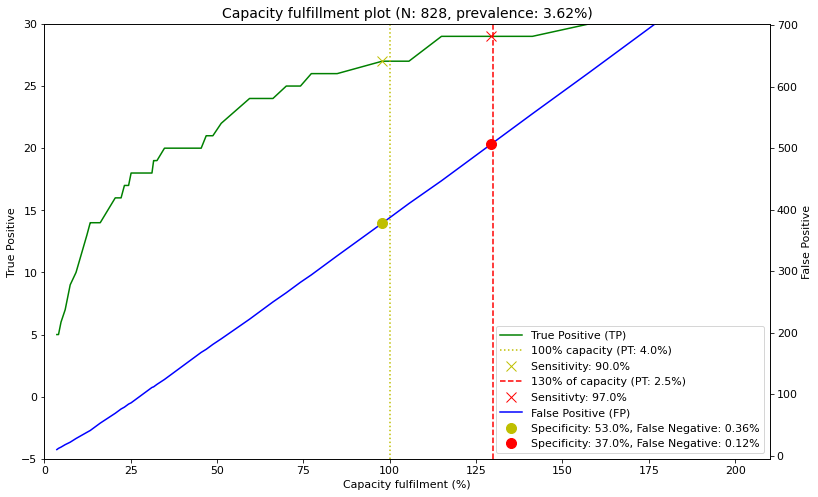

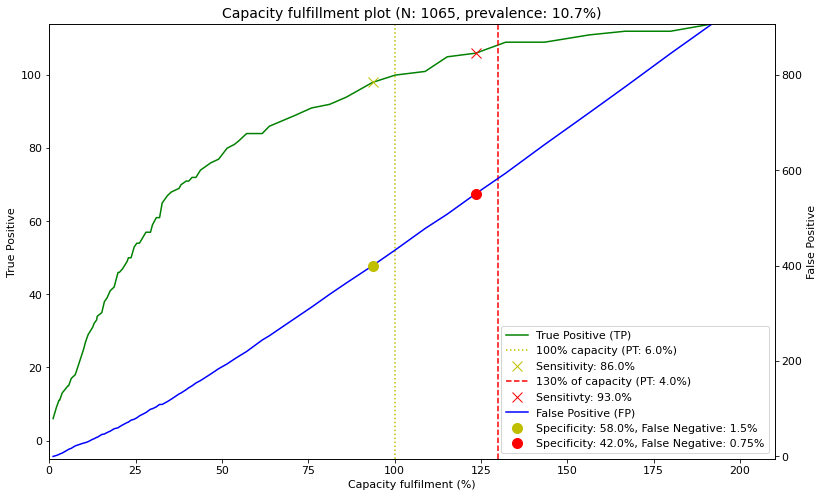

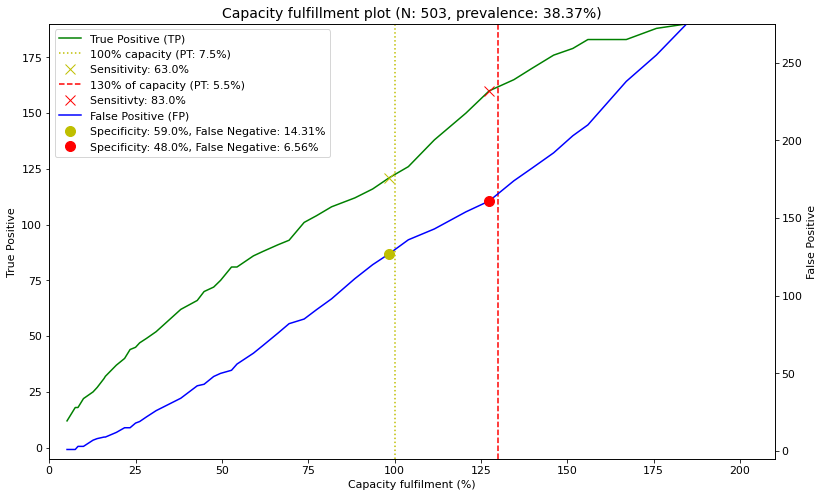

In [67]:
## for POSTER


import matplotlib
# 
SMALL_SIZE = 11
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

x = 'CAP_DIFF'
y_1 = 'TP'
y_2 = 'FP'
y_3 = 'FN'
max_xlim = 210 #max % pf capacity to be plotted

clinic = 1
for practice_id in practice_ids:
    data_output = output[(output.practice == practice_id)&(output.model=='XGB')]
    fig, ax = plt.subplots(figsize=(13,8))
    data_output.plot(ax = ax, x=x, y=y_1, color='green', label='True Positive (TP)')
    # ax.title.set_text('PM2.5 Design Values')
    ax.set_xlim(0,max_xlim)
    # ax.set_ylim(0,data_output[data_output.CAP_DIFF < max_xlim][y_2].values[0]) #set ylim based on the y2 value at CAP_DIFF ~ max_xlim
    ax.set_ylim(-5,data_output[y_1].max()) #set ylim based on the max value of y1
    # ax.tick_params(axis='y', labelcolor='tab:green')
    ax.set_ylabel('True Positive')
    ax.set_xlabel('Capacity fulfilment (%)')
    ax2 = ax.twinx() #for the 2nd y-axis
    ax2.set_ylim(-5,data_output[y_2].max())
    ax2.set_ylabel('False Positive')
    
    # ax.set_xticks(IVdv.index)
    
    
    ax2.plot(data_output[x], data_output[y_2], color='blue', 
            label='False Positive (FP)')
    
    # ax2.plot(data_output[x], data_output[y_3], color='black', 
    #         label='False Negative (FN)')
    
    
    
    # ax2.set_ylim(0,data_output[data_output.CAP_DIFF < max_xlim][y_2].values[0]) #set ylim based on the y2 value at CAP_DIFF ~ max_xlim
    # ax2.set_ylim(0,data_output[y_2].max()) #set ylim based on the max value of y2
    # ax2.tick_params(axis='y', labelcolor='tab:blue')
    # ax2.set_ylabel('False Positive')

    #plot ideal capacity at 100%
    capacity = data_output.Capacity.values[0]
    x_mark = data_output[(data_output.CAP_DIFF <= 100)].CAP_DIFF.values[0]
    tp_mark = data_output[(data_output.CAP_DIFF == x_mark)].TP.values[0]
    fp_mark = data_output[(data_output.CAP_DIFF == x_mark)].FP.values[0]
    fn_mark = data_output[(data_output.CAP_DIFF == x_mark)].FN.values[0]
    pt_mark = data_output[(data_output.CAP_DIFF == x_mark)].threshold.values[0]
    sens = np.round(data_output[(data_output.CAP_DIFF == x_mark)].SENS.values[0],2)
    spec = np.round(data_output[(data_output.CAP_DIFF == x_mark)].SPEC.values[0],2)

    # ax3 = ax2.twinx() #for vertical lines

    ax.axvline(x=100, color='y', label=f'100% capacity (PT: {pt_mark*100}%)', ls=':')
    ax.plot(x_mark, tp_mark, ls="", color='y', marker="x", markersize=10, label=f"Sensitivity: {np.round(sens*100,1)}%")
    # ax.annotate(, (x_mark-50, tp_mark-30))
    ax2.plot(x_mark, fp_mark, ls="", color='y', marker="o", markersize=10, label=f"Specificity: {np.round(spec*100,1)}%, False Negative: {np.round(fn_mark/data_output.n.values[0]*100,2)}%")
    # ax2.plot(x_mark, fn_mark, ls="", color='y', marker="*", markersize=10, label=f"{fn_mark}")
    
    
    # ax.annotate(, (x_mark-50, fp_mark+7))
    # ax.annotate(f"Ideal probability threshold: {pt_mark}")

    #plot capacity at 130%
    x_mark = data_output[(data_output.CAP_DIFF <= 130)].CAP_DIFF.values[0]
    tp_mark = data_output[(data_output.CAP_DIFF == x_mark)].TP.values[0]
    fp_mark = data_output[(data_output.CAP_DIFF == x_mark)].FP.values[0]
    fn_mark = data_output[(data_output.CAP_DIFF == x_mark)].FN.values[0]
    pt_mark = data_output[(data_output.CAP_DIFF == x_mark)].threshold.values[0]
    sens = np.round(data_output[(data_output.CAP_DIFF == x_mark)].SENS.values[0],2)
    spec = np.round(data_output[(data_output.CAP_DIFF == x_mark)].SPEC.values[0],2)
    

    ax.axvline(x=130, color='r', label=f'130% of capacity (PT: {pt_mark*100}%)', ls='--')
    ax.plot(x_mark, tp_mark, ls="", marker="x", markersize=10, color='r', label=f"Sensitivty: {np.round(sens*100,1)}%")
    # ax.annotate(, (x_mark+1, tp_mark-20))
    ax2.plot(x_mark, fp_mark, ls="", marker="o", markersize=10, color='r', label=f"Specificity: {np.round(spec*100,1)}%, False Negative: {np.round(fn_mark/data_output.n.values[0]*100,2)}%")
    # ax2.plot(x_mark, fn_mark, ls="", color='r', marker="*", markersize=10, label=r"FN ($ \lesssim $ 130% capacity): " + f"{fn_mark}")
    
    
    # ax.annotate(, (x_mark+1, fp_mark+7))
    # ax.annotate(f"Probability threshold fpr 130% capacity: {pt_mark}")
    # plt.gca().set_yticks(np.arange(0, 1000, 100))
    
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
 
    
    lines = lines_1 + lines_2 
    labels = labels_1 + labels_2 
    
    ax.legend(lines, labels, loc='best')
    n = data_output.n.values[0]
    event_rate = np.round(data_output.event_rate.values[0]*100, 2)
    plt.title(f'Capacity fulfillment plot (N: {n}, prevalence: {event_rate}%)', fontsize=14)
    clinic+=1
    # plt.legend()

In [57]:
data_output

,practice,n,event_rate,model,threshold,TP,FP,TN,FN,SPEC,SENS,Capacity,CAP_DIFF
1007,1105,503,0.383698,XGB,0.010,190,275,35,3,0.112903,0.984456,252,184.523810
1008,1105,503,0.383698,XGB,0.015,188,255,55,5,0.177419,0.974093,252,175.793651
1009,1105,503,0.383698,XGB,0.020,183,238,72,10,0.232258,0.948187,252,167.063492
1010,1105,503,0.383698,XGB,0.025,183,218,92,10,0.296774,0.948187,252,159.126984
1011,1105,503,0.383698,XGB,0.030,183,210,100,10,0.322581,0.948187,252,155.952381
1012,1105,503,0.383698,XGB,0.035,179,203,107,14,0.345161,0.927461,252,151.587302
1013,1105,503,0.383698,XGB,0.040,176,192,118,17,0.380645,0.911917,252,146.031746
1014,1105,503,0.383698,XGB,0.045,170,182,128,23,0.412903,0.880829,252,139.682540
1015,1105,503,0.383698,XGB,0.050,165,174,136,28,0.438710,0.854922,252,134.523810
1016,1105,503,0.383698,XGB,0.055,160,161,149,33,0.480645,0.829016,252,127.380952


In [ ]:
allData.columns

In [ ]:
features_candidate = ['sex', 'age', 'BMI', 'ethnic_group', 'smokingStatus',
       'imd_decile', 'CharlsonScore', 'count_rhinitis', 'count_cardiovascular',
       'count_heartfailure', 'count_psoriasis', 'count_anaphylaxis',
       'count_diabetes', 'count_ihd', 'count_anxiety', 'count_eczema',
       'count_nasalpolyps', 'count_paracetamol', 'count_nsaids',
       'count_betablocker', 'PEFStatus', 'EosinophilLevel', 'BTS_step',
       'DeviceType', 'PriorEducation', 'average_daily_dose_ICS',
       'prescribed_daily_dose_ICS', 'ICS_medication_possesion_ratio', 'numPCS',
       'numPCSAsthma', 'numAntibioticsEvents', 'numAntibioticswithLRTI',
       'numOCSEvents', 'numOCSwithLRTI', 'numAsthmaAttacks',
       'numAcuteRespEvents', 'numHospEvents', 'numAsthmaManagement',
       'numAsthmaReview', 'numAsthmaMedReview', 'numAsthmaReviewRCP']
len(features_candidate)

In [ ]:
#onehot encoding for categorical variables
onehot_vars = ['BMI_cat', 'ethnic_group', 'smokingStatus', 'imd_decile', 'CharlsonScore',
               'PEFStatus', 'EosinophilLevel', 'BTS_step', 'DeviceType',  'PriorEducation',]
allData = pd.get_dummies(allData, columns=onehot_vars, dtype='int')
allData.columns

In [ ]:
#make sure get_dummies use 1 0 not true false
allData.iloc[:,80:]

In [ ]:
#Split training set into grid search, cross val, and internal validation

trainingData = allData[(allData.set == 'training')] #& (allData.age>=18)
gridSearchData, crossValData = train_test_split(trainingData, train_size=0.05, stratify=trainingData['outcome_12months'], random_state=random_state)
crossValData, internalEvaluationData = train_test_split(crossValData, test_size=0.215, stratify=crossValData['outcome_12months'],  random_state=random_state)
gridSearchData.reset_index(drop=True, inplace=True)
crossValData.reset_index(drop=True, inplace=True)
internalEvaluationData.reset_index(drop=True, inplace=True)

In [ ]:
#Proportion of asthma attack in each outcome - training

print('3 months -> ', round(gridSearchData['outcome_3months'].value_counts()[1]/len(gridSearchData)*100,2), '%')
print('6 months -> ', round(gridSearchData['outcome_6months'].value_counts()[1]/len(gridSearchData)*100,2), '%')
print('9 months -> ', round(gridSearchData['outcome_9months'].value_counts()[1]/len(gridSearchData)*100,2), '%')
print('12 months -> ', round(gridSearchData['outcome_12months'].value_counts()[1]/len(gridSearchData)*100,2), '%')
# print('3 months -> ', round(trainingData['outcome_3months'].value_counts()[1]/len(trainingData)*100,2), '%')
# print('6 months -> ', round(trainingData['outcome_combined_6months'].value_counts()[1]/len(trainingData)*100,2), '%')
# print('9 months -> ', round(trainingData['outcome_combined_9months'].value_counts()[1]/len(trainingData)*100,2), '%')
# print('12 months -> ', round(trainingData['outcome_combined_12months'].value_counts()[1]/len(trainingData)*100,2), '%')
# print('24 months -> ', round(trainingData['outcome_combined_24months'].value_counts()[1]/len(trainingData)*100,2), '%')

In [ ]:
#Proportion of asthma attack in each outcome - validation

print('3 months -> ', round(crossValData['outcome_3months'].value_counts()[1]/len(crossValData)*100,2), '%')
print('6 months -> ', round(crossValData['outcome_6months'].value_counts()[1]/len(crossValData)*100,2), '%')
print('9 months -> ', round(crossValData['outcome_9months'].value_counts()[1]/len(crossValData)*100,2), '%')
print('12 months -> ', round(crossValData['outcome_12months'].value_counts()[1]/len(crossValData)*100,2), '%')
# print('3 months -> ', round(validationData['outcome_3months'].value_counts()[1]/len(validationData)*100,2), '%')
# print('6 months -> ', round(validationData['outcome_combined_6months'].value_counts()[1]/len(validationData)*100,2), '%')
# print('9 months -> ', round(validationData['outcome_combined_9months'].value_counts()[1]/len(validationData)*100,2), '%')
# print('12 months -> ', round(validationData['outcome_combined_12months'].value_counts()[1]/len(validationData)*100,2), '%')
# print('24 months -> ', round(validationData['outcome_combined_24months'].value_counts()[1]/len(validationData)*100,2), '%')

In [ ]:
#Proportion of asthma attack in each outcome - internalEvaluation

print('3 months -> ', round(internalEvaluationData['outcome_3months'].value_counts()[1]/len(internalEvaluationData)*100,2), '%')
print('6 months -> ', round(internalEvaluationData['outcome_6months'].value_counts()[1]/len(internalEvaluationData)*100,2), '%')
print('9 months -> ', round(internalEvaluationData['outcome_9months'].value_counts()[1]/len(internalEvaluationData)*100,2), '%')
print('12 months -> ', round(internalEvaluationData['outcome_12months'].value_counts()[1]/len(internalEvaluationData)*100,2), '%')

In [ ]:
externalEvaluationData = allData[allData.set == 'evaluation']
externalEvaluationData = externalEvaluationData.drop_duplicates('patid')
externalEvaluationData.reset_index(drop=True, inplace=True)
print('size: ', externalEvaluationData.shape)
#Proportion of asthma attack in each outcome - internalEvaluation

print('3 months -> ', round(externalEvaluationData['outcome_3months'].value_counts()[1]/len(externalEvaluationData)*100,2), '%')
print('6 months -> ', round(externalEvaluationData['outcome_6months'].value_counts()[1]/len(externalEvaluationData)*100,2), '%')
print('9 months -> ', round(externalEvaluationData['outcome_9months'].value_counts()[1]/len(externalEvaluationData)*100,2), '%')
print('12 months -> ', round(externalEvaluationData['outcome_12months'].value_counts()[1]/len(externalEvaluationData)*100,2), '%')

In [ ]:
print(f'Grid search size: {gridSearchData.shape}')
print(f'Cross val size: {crossValData.shape}')
print(f'Internal val size: {internalEvaluationData.shape}')
print(f'External val size: {externalEvaluationData.shape}')

In [ ]:
#Save original data
# trainingData.to_csv('../FinalData/trainingData_2vs1_16112023.csv', index_label=False, index=False)
# validationData.to_csv('../FinalData/validationData_2vs1_16112023.csv', index_label=False, index=False)
# internalEvaluationData.to_csv('../FinalData/internalEvalulationData_2vs1_16112023.csv', index_label=False, index=False)
# evaluationData.to_csv('../FinalData/evaluationData_2vs1_16112023.csv', index_label=False, index=False)
# evaluationDataWales.to_csv('../FinalData/evaluationDataWales_2vs1_16112023.csv', index_label=False, index=False)
# evaluationDataScotland.to_csv('../FinalData/evaluationDataScotland_2vs1_16112023.csv', index_label=False, index=False)
sets = [gridSearchData, crossValData, internalEvaluationData, externalEvaluationData]
pickle.dump(sets, open('../Clean_data/dataset_2vs1_25102024.sav', 'wb'))

In [ ]:
# #encode categorical data
# # 
# # cat_vars = [, 'PEFStatus','EosinophilLevel']
# # data_categorical = trainingData[cat_vars]
# onehot_vars = ['ethnic_group','smokingStatus', 'DeviceType', 'cat_BMI', 'imd_decile', 'PEFStatus','EosinophilLevel', 'BTS_step']
# data_onehot = trainingData[onehot_vars]

# #ordinal encoder
# # encoder = OrdinalEncoder(categories=[['not_recorded','less than 60', '60-80', 'more than 80'], ['unknown', 'normal', 'high']]).set_output(transform="pandas")
# # data_encoded = encoder.fit_transform(data_categorical)
# # pickle.dump(encoder, open('../Models/cat_encoder.pkl', 'wb'))
    
# #one hot encoder
# onehot_encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
# onehot_encoded = onehot_encoder.fit_transform(data_onehot)
# pickle.dump(onehot_encoder, open('../Models/onehot_encoder.pkl', 'wb'))

# # trainingData = pd.concat([trainingData.drop(cat_vars, axis=1), data_encoded], axis=1)
# trainingData = pd.concat([trainingData.drop(onehot_vars, axis=1), onehot_encoded], axis=1)

# print('Data shape after encoding: ', trainingData.shape)

In [ ]:
# #encode cat vars for validation and evaluation set
# # data_val_categorical = validationData[cat_vars]
# data_val_onehot = validationData[onehot_vars]
# data_internaleval_onehot = internalEvaluationData[onehot_vars]
# # data_eval_categorical = evaluationData[cat_vars]
# data_eval_onehot = evaluationData[onehot_vars]
# # data_eval_Wales_categorical = evaluationDataWales[cat_vars]
# data_eval_Wales_onehot = evaluationDataWales[onehot_vars]
# # data_eval_Scotland_categorical = evaluationDataScotland[cat_vars]
# data_eval_Scotland_onehot = evaluationDataScotland[onehot_vars]

# # encoder = pickle.load(open('../Models/cat_encoder.pkl', 'rb'))
# # data_val_encoded = encoder.transform(data_val_categorical)
# # data_eval_encoded = encoder.transform(data_eval_categorical)
# # data_eval_Wales_encoded = encoder.transform(data_eval_Wales_categorical)
# # data_eval_Scotland_encoded = encoder.transform(data_eval_Scotland_categorical)

# onehot_encoder = pickle.load(open('../Models/onehot_encoder.pkl', 'rb'))
# onehot_val_encoded = onehot_encoder.transform(data_val_onehot)
# onehot_internaleval_encoded = onehot_encoder.transform(data_internaleval_onehot)
# onehot_eval_encoded = onehot_encoder.transform(data_eval_onehot)
# onehot_eval_Wales_encoded = onehot_encoder.transform(data_eval_Wales_onehot)
# onehot_eval_Scotland_encoded = onehot_encoder.transform(data_eval_Scotland_onehot)

# # validationData = pd.concat([validationData.drop(cat_vars, axis=1), data_val_encoded], axis=1)
# validationData = pd.concat([validationData.drop(onehot_vars, axis=1), onehot_val_encoded], axis=1)

# # evaluationData = pd.concat([evaluationData.drop(cat_vars, axis=1), data_eval_encoded], axis=1)
# internalEvaluationData = pd.concat([internalEvaluationData.drop(onehot_vars, axis=1), onehot_internaleval_encoded], axis=1)

# # evaluationData = pd.concat([evaluationData.drop(cat_vars, axis=1), data_eval_encoded], axis=1)
# evaluationData = pd.concat([evaluationData.drop(onehot_vars, axis=1), onehot_eval_encoded], axis=1)

# # evaluationDataWales = pd.concat([evaluationDataWales.drop(cat_vars, axis=1), data_eval_Wales_encoded], axis=1)
# evaluationDataWales = pd.concat([evaluationDataWales.drop(onehot_vars, axis=1), onehot_eval_Wales_encoded], axis=1)

# # evaluationDataScotland = pd.concat([evaluationDataScotland.drop(cat_vars, axis=1), data_eval_Scotland_encoded], axis=1)
# evaluationDataScotland = pd.concat([evaluationDataScotland.drop(onehot_vars, axis=1), onehot_eval_Scotland_encoded], axis=1)

# print('Val data shape after encoding: ', validationData.shape)
# print('Internal Eval data shape after encoding: ', internalEvaluationData.shape)
# print('Eval data shape after encoding: ', evaluationData.shape)
# print('Evaluation data Wales shape: ', evaluationDataWales.shape)
# print('Evaluation data Scotland shape: ', evaluationDataScotland.shape)

In [ ]:
# Cont Var Scalling

In [ ]:
allData.columns.values

In [ ]:
continuous_vars = ['age', 'average_daily_dose_ICS', 'prescribed_daily_dose_ICS',
                   'ICS_medication_possesion_ratio', 'numPCS', 'numPCSAsthma',
                   'numAntibioticsEvents', 'numAntibioticswithLRTI', 'numOCSEvents',
                   'numOCSwithLRTI', 'numAsthmaAttacks', 'numAcuteRespEvents',
                   'numHospEvents', 'numAsthmaManagement', 'numAsthmaReview',
                   'numAsthmaMedReview', 'numAsthmaReviewRCP',]
len(continuous_vars)

In [ ]:
#Data normalisation for continous variable into 0-1 range based on gridSearch set

# define scaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(gridSearchData[continuous_vars])
pickle.dump(scaler, open('../Models/cont_scaler.pkl', 'wb'))


data_scaled = pd.DataFrame(data_scaled, columns=scaler.get_feature_names_out())
gridSearchData = pd.concat([gridSearchData.drop(continuous_vars, axis=1), data_scaled], axis=1)

print('Data shape after scaling: ', gridSearchData.shape)

In [ ]:
#Normalisation for other sets

scaler = pickle.load(open('../Models/cont_scaler.pkl', 'rb'))
data_val_scaled = scaler.transform(crossValData[continuous_vars])
data_internal_eval_scaled = scaler.transform(internalEvaluationData[continuous_vars])
data_external_eval_scaled = scaler.transform(externalEvaluationData[continuous_vars])

data_val_scaled = pd.DataFrame(data_val_scaled, columns=scaler.get_feature_names_out())
crossValData = pd.concat([crossValData.drop(continuous_vars, axis=1), data_val_scaled], axis=1)

data_internal_eval_scaled = pd.DataFrame(data_internal_eval_scaled, columns=scaler.get_feature_names_out())
internalEvaluationData = pd.concat([internalEvaluationData.drop(continuous_vars, axis=1), data_internal_eval_scaled], axis=1)

data_external_eval_scaled = pd.DataFrame(data_external_eval_scaled, columns=scaler.get_feature_names_out())
externalEvaluationData = pd.concat([externalEvaluationData.drop(continuous_vars, axis=1), data_external_eval_scaled], axis=1)


print('Val data shape after scaling: ', crossValData.shape)
print('Eval data shape after scaling: ', internalEvaluationData.shape)
print('Evaluation data Wales shape: ', externalEvaluationData.shape)

In [ ]:
#Define feature candidates

features_columns = gridSearchData.columns.to_list()
exclude_columns = ['patid', 'practice_id', 'set', #identifier
                   'BMI', #use the categorical instead
                   'ethnicity', #use ethnic_group instead
                   'Spacer',  #all zero
                   
                   'outcome_3months', 'outcome_6months', 'outcome_9months', 'outcome_12months', 'outcome_15months', 'outcome_18months', 
                   'outcome_21months', 'outcome_24months', 'outcome_combined_6months', 'outcome_combined_9months', 'outcome_combined_12months', 
                   'outcome_combined_15months', 'outcome_combined_18months', 'outcome_combined_24months', '3months', '6months', '12months', '24months', #outcomes variable
                   
                   'postcode_district', 'County', 'LocalAuthority', 'OutputAreaClassification', #location related variables, use IMD decile only
                   
                   'age_cat', 'ICS_medication_possesion_ratio_cat', 'numOCS_cat', 'numOCSEvents_cat', 'numOCSwithLRTI_cat', 'numAcuteRespEvents_cat', 
                   'numAntibioticsEvents_cat', 'numAntibioticswithLRTI_cat', 'numAsthmaAttacks_cat', 'numHospEvents_cat', 'numPCS_cat', 'numPCSAsthma_cat', 
                   'numAsthmaManagement_cat', 'numAsthmaReview_cat', 'numAsthmaMedReview_cat', 'numAsthmaReviewRCP_cat', 'average_daily_dose_ICS_cat', 
                   'prescribed_daily_dose_ICS_cat', #use continous vars instead
                   
                   'count_rhinitis', 'count_cardiovascular', 'count_heartfailure',
                   'count_psoriasis', 'count_anaphylaxis', 'count_diabetes', 'count_ihd',
                   'count_anxiety', 'count_eczema', 'count_nasalpolyps',
                   'count_paracetamol', 'count_nsaids', 'count_betablocker', #use binary ones
                   
                   'paracetamol', 'nsaids', 'betablocker', #no data in evaluation
                                      
                  ]
# exclude_columns = exclude_columns + [x for x in features_columns if '_count' in x] #filter out commorbid count variables
features_columns = [x for x in features_columns if x not in exclude_columns]
print('Features size: ', len(features_columns))
print(features_columns)

In [ ]:
#make sure no data leak between sets
print(list(set(gridSearchData.patid.values).intersection(set(crossValData.patid.values))))
print(list(set(gridSearchData.patid.values).intersection(set(internalEvaluationData.patid.values))))
print(list(set(crossValData.patid.values).intersection(set(internalEvaluationData.patid.values))))
print(list(set(crossValData.patid.values).intersection(set(externalEvaluationData.patid.values))))
print(list(set(gridSearchData.patid.values).intersection(set(externalEvaluationData.patid.values))))


In [ ]:
#Save encoded data
# trainingData.to_csv('../FinalData/trainingDataEncoded_2vs1_16112023.csv', index_label=False, index=False)
# validationData.to_csv('../FinalData/validationDataEncoded_2vs1_16112023.csv', index_label=False, index=False)
# internalEvaluationData.to_csv('../FinalData/internalEvaluationDataEncoded_2vs1_16112023.csv', index_label=False, index=False)
# evaluationData.to_csv('../FinalData/evaluationDataEncoded_2vs1_16112023.csv', index_label=False, index=False)
# evaluationDataWales.to_csv('../FinalData/evaluationDataWalesEncoded_2vs1_16112023.csv', index_label=False, index=False)
# evaluationDataScotland.to_csv('../FinalData/evaluationDataScotlandEncoded_2vs1_16112023.csv', index_label=False, index=False)
sets = [gridSearchData, crossValData, internalEvaluationData, externalEvaluationData]
pickle.dump(sets, open('../Clean_data/dataset_scaled_2vs1_25102024.sav', 'wb'))